<h1>UnderSampling + Baggingでimbalancedなデータを学習</h1>


In [585]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader , TensorDataset

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE 

import pandas as pd
import numpy as np

In [800]:
#データの読み込みとデータ処理
data_ =  pd.read_csv("./data/bank-additional-full.csv", sep=";").drop('duration',axis=1).drop('day_of_week',axis=1).sample(frac=1)
print(data_.shape)
data_.head()

(41188, 19)


,age,job,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
14403,33,blue-collar,married,high.school,no,yes,no,cellular,jul,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
17889,47,admin.,divorced,university.degree,no,no,no,cellular,jul,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
35434,29,admin.,divorced,professional.course,no,yes,yes,cellular,may,6,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
33739,36,blue-collar,married,basic.6y,unknown,yes,yes,cellular,may,9,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,no
38827,31,services,married,high.school,no,no,no,telephone,nov,2,3,2,success,-3.4,92.649,-30.1,0.714,5017.5,yes


In [801]:
data = data_.copy()
data.y = data.y.replace({'yes':1,'no':0})
data.pdays[data.pdays == 999] = 0
data.pdays[data.pdays != 0] = 1
data['month'].loc[(data['month'] == 'apr') | (data['month'] == 'may')| (data['month'] == 'jun')] = 'spr'
data['month'].loc[(data['month'] == 'jul') | (data['month'] == 'aug')| (data['month'] == 'sep')] = 'sum'
data['month'].loc[(data['month'] == 'oct') | (data['month'] == 'nov')| (data['month'] == 'dec')] = 'aut'
data['month'].loc[(data['month'] == 'jan') | (data['month'] == 'feb')| (data['month'] == 'mar')] = 'win'
data.head()

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

,age,job,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
14403,33,blue-collar,married,high.school,no,yes,no,cellular,sum,3,0,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
17889,47,admin.,divorced,university.degree,no,no,no,cellular,sum,1,0,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0
35434,29,admin.,divorced,professional.course,no,yes,yes,cellular,spr,6,0,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0
33739,36,blue-collar,married,basic.6y,unknown,yes,yes,cellular,spr,9,0,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,0
38827,31,services,married,high.school,no,no,no,telephone,aut,2,1,2,success,-3.4,92.649,-30.1,0.714,5017.5,1


In [802]:
data['age'] = pd.cut(data['age'],[10,20,30,40,50,60,70,80,90,100],labels = ['10','20','30','40','50','60','70','80','90'])

data = pd.get_dummies(data)
data['Y'] = data['y']
data = data.drop('y',axis=1).drop('job_unknown',axis=1).drop('marital_unknown',axis=1).drop('education_unknown',axis=1).drop('default_unknown',axis=1).drop('housing_unknown',axis=1).drop('loan_unknown',axis=1)
#data['age'] = pd.cut(data['age'],[10,20,30,40,50,60,70,80,90,100],labels = [10,20,30,40,50,60,70,80,90])


data.head(3)

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age_10,age_20,...,contact_cellular,contact_telephone,month_aut,month_spr,month_sum,month_win,poutcome_failure,poutcome_nonexistent,poutcome_success,Y
14403,3,0,0,1.4,93.918,-42.7,4.962,5228.1,0,0,...,1,0,0,0,1,0,0,1,0,0
17889,1,0,0,1.4,93.918,-42.7,4.961,5228.1,0,0,...,1,0,0,0,1,0,0,1,0,0
35434,6,0,0,-1.8,92.893,-46.2,1.244,5099.1,0,1,...,1,0,0,1,0,0,0,1,0,0


In [803]:
data.head(10)

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age_10,age_20,...,contact_cellular,contact_telephone,month_aut,month_spr,month_sum,month_win,poutcome_failure,poutcome_nonexistent,poutcome_success,Y
14403,3,0,0,1.4,93.918,-42.7,4.962,5228.1,0,0,...,1,0,0,0,1,0,0,1,0,0
17889,1,0,0,1.4,93.918,-42.7,4.961,5228.1,0,0,...,1,0,0,0,1,0,0,1,0,0
35434,6,0,0,-1.8,92.893,-46.2,1.244,5099.1,0,1,...,1,0,0,1,0,0,0,1,0,0
33739,9,0,0,-1.8,92.893,-46.2,1.281,5099.1,0,0,...,1,0,0,1,0,0,0,1,0,0
38827,2,1,2,-3.4,92.649,-30.1,0.714,5017.5,0,0,...,0,1,1,0,0,0,0,0,1,1
5080,3,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,1,0,1,0,0,0,1,0,0
30656,3,0,0,-1.8,92.893,-46.2,1.344,5099.1,0,0,...,1,0,0,1,0,0,0,1,0,0
18029,1,0,0,1.4,93.918,-42.7,4.963,5228.1,0,0,...,0,1,0,0,1,0,0,1,0,0
11653,3,0,0,1.4,94.465,-41.8,4.959,5228.1,0,0,...,0,1,0,1,0,0,0,1,0,0
6350,3,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,1,0,1,0,0,0,1,0,0


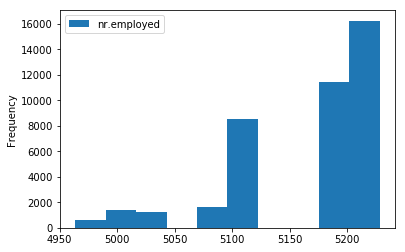

In [804]:
%matplotlib inline
import matplotlib.pyplot as plt


pd.DataFrame(data_['nr.employed']).plot(kind='hist',bins=50)

In [792]:
data_.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


In [797]:
for column in 'job','marital','education','default','housing','loan','contact','month','poutcome':
    print("===" + str(column) + "===")
    print(data_[column].value_counts())
    print(" ")

===job===
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
 
===marital===
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
 
===education===
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
 
===default===
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
 
===housing===
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
 
===loan===
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64
 
===contact===

In [805]:
# データを訓練データと評価データに分割
train_data = data[:int(len(data)*0.7)]
test_data = data[int(len(data)*0.7):]

train_data.shape

(28831, 54)

In [806]:
# 訓練データを少数クラスのデータと多数クラスに分割
#train_data_success = train_data[train_data['poutcome_success'] == 1]
#train_data_failed = train_data[train_data['poutcome_success'] == 0]
train_data_1 = train_data[train_data['Y'] == 1]
train_data_0 = train_data[train_data['Y'] == 0]

In [807]:
# yが 1 なのは全体の1/10くらい
len(train_data_1)/len(train_data_failed)

0.11456763545030499

<h2>ニューラルネットワークモデル定義</h2>
<h4>GridSearchCVとかPipelineが便利なので、sklearnのBaseEstimatorを継承しました</h4>

In [808]:
from sklearn.base import BaseEstimator
from sklearn.base import BaseEstimator, ClassifierMixin

OUTPUT_SIZE=2

class skNN(BaseEstimator,nn.Module,ClassifierMixin):
    def __init__(self, input_layer=20,hidden_layer=20,lr=0.01):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.lr = lr
        
        super(skNN, self).__init__()
        self.fc1 = nn.Linear(self.input_layer,self.hidden_layer)
        self.fc2 = nn.Linear(self.hidden_layer,self.hidden_layer)
        self.fc3 = nn.Linear(self.hidden_layer,OUTPUT_SIZE)
        self.outact = nn.Softmax()
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(),lr=self.lr)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x)
        x = self.fc3(x)
        return self.outact(x)
        
    def fit(self, X, y=None, **params):
        self.input_layer = len(X[0])
        self.fc1 = nn.Linear(self.input_layer,self.hidden_layer)
        
        tensorX = torch.from_numpy(X).float()
        tensorY = torch.from_numpy(y).long()
        train = TensorDataset(tensorX,tensorY)
        train_loader = DataLoader(train, batch_size=32, shuffle=True)

        for epoch in range(int(len(X)/32)):
            total_loss = 0    
            for train_x, train_y in train_loader:
                train_x, train_y = Variable(train_x), Variable(train_y)
                self.optimizer.zero_grad()
                output = self(train_x)
                loss = self.criterion(output, train_y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.data[0]
            
            if (epoch+1) % 50 == 0:
                print(epoch+1, total_loss)
        return self
    
    def predict(self, X):
        tensorX = torch.from_numpy(X).float()
        test_X = Variable(tensorX)
        return (self(test_X).data[:,1].numpy() > 0.5).astype(int)
    
    def predict_proba(self, X):
        tensorX = torch.from_numpy(X).float()
        test_X = Variable(tensorX)
        return self(test_X).data[:,1].numpy()
    
    def score(self,X,y):
        tensorX = torch.from_numpy(X).float()
        test_X = Variable(tensorX)
        return sum( (self(test_X).data[:,1].numpy() > 0.5).astype(int) == y )/ len(y)
    
    def get_params(self,deep=True):
        return {'hidden_layer': self.hidden_layer, 'lr': self.lr}
    
    def set_params(self,**params):
        for parameter, value in params.items():
            setattr(self,parameter, value)
        self.fc1 = nn.Linear(self.input_layer,self.hidden_layer)
        self.fc2 = nn.Linear(self.hidden_layer,self.hidden_layer)
        self.fc3 = nn.Linear(self.hidden_layer,OUTPUT_SIZE)
        self.optimizer = optim.Adam(self.parameters(),lr=self.lr)
        return self
        

<h2>学習実行</h2>
<h4>折角なので色んな種類の識別器を使ってみます。それぞれでグリッドサーチし、最適なパラメータを探索しています</h4>

In [810]:
# 識別器の定義
from sklearn.linear_model import LogisticRegression
from sklearn import svm
clfs = {"GB1":GradientBoostingClassifier(),
        "GB2":GradientBoostingClassifier(),
        "GB3":GradientBoostingClassifier(),
        "GB4":GradientBoostingClassifier(),
        "GB5":GradientBoostingClassifier(),
        "GB6":GradientBoostingClassifier(),
        "GB7":GradientBoostingClassifier(),
        "NN":skNN()
       }


In [811]:
# 各Estimatorのパラメータ探索用dict
gb_parameters = {
    "select__threshold" : ["mean", "median"],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth":[7,9],
    "clf__subsample":[0.5, 1.0],
    "clf__n_estimators":[10]
}
rf_parameters = {
    "clf__n_estimators" : [100],
    "clf__max_features" : [1, 'auto', None],
    "clf__max_depth" : [1, 5, 10, None],
    "clf__min_samples_leaf": [1, 2, 4,]
}
lr_parameters = {
    "clf__C": [0.01,0.1,1]
}
svc_parameters = {
    "clf__C": [1,10,100],
    "clf__gamma": [0.01,0.1,1]
}
nn_parameters = {
    "select__threshold" : ["mean", "median"],
    "clf__hidden_layer": [30,40,50],
    "clf__lr": [0.01],
}

In [812]:
train_data_feature.shape

(8042, 45)

In [813]:
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline 
i=0

# 識別器格納用リスト
# 8種類の識別器が格納される
gb_clfs = []

# 各識別器に対して学習実行
for clf in clfs.items():
    i += 1
    print(i) 
    
    # 多数データを少数データの数だけUnderSamplingし、少数データとマージ
    train_data_ = np.vstack((train_data_0.sample(n=int(4*len(train_data_1))),train_data_1.sample(n=int(len(train_data_1)))))
    # マージ後の訓練データをシャッフル
    np.random.shuffle(train_data_)
    # 訓練データを説明変数と目的変数に分割
    train_data_feature = train_data_[:,:-1].astype(float)
    train_data_target = train_data_[:,-1].astype(float)
    
    # 説明変数(特徴量)抽出モデルと標準化モデルを定義
    select = SelectFromModel(RandomForestClassifier(n_estimators=100, n_jobs=-1))
    pca = PCA()
    sm = SMOTE()
    scaler = StandardScaler()
    
    # 一連の処理(Pipeline)を定義
    # 特徴量抽出→標準化→識別器訓練
    estimator = [
        ('select',select),
        #('pca',pca),
        ('smote' ,sm),
        ('scaler',scaler),
        ('clf',clf[1])
    ]

    pipe = Pipeline(estimator)
    
    # グリッドサーチ用モデルの定義
    # 識別器の種類によってパラメータが異なるので条件分岐
    if clf[0] == 'SVC':
        gb_clf = GridSearchCV(pipe, svc_parameters, scoring='f1', cv=3, n_jobs=-1)
    elif clf[0] == 'RF':
        gb_clf = GridSearchCV(pipe, rf_parameters, scoring='f1', cv=3, n_jobs=-1)
    elif clf[0] =='NN':
        gb_clf = GridSearchCV(pipe, nn_parameters, scoring='f1', cv=3, n_jobs=-1)
    elif clf[0].find('LR') > -1:
        gb_clf = GridSearchCV(pipe, lr_parameters, scoring='f1', cv=3, n_jobs=-1)
    else:
        gb_clf = GridSearchCV(pipe, gb_parameters, scoring='f1', cv=3, n_jobs=-1)

    # グリッドサーチ実行
    gb_clf.fit(train_data_feature,train_data_target)
    
    # 最適なパラメータで訓練された識別器をリストに追加
    gb_clfs.append(gb_clf)

1
2
3
4
5
6
7
8


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension ch

50 tensor(280.2358)
50 tensor(287.6408)
50 tensor(287.1967)
50 tensor(280.7770)
100 tensor(275.5715)
100 tensor(283.4546)
100 tensor(276.5577)
100 tensor(284.0502)
150 tensor(272.6907)
150 tensor(279.8647)
150 tensor(275.9604)
150 tensor(281.8017)
200 tensor(271.4343)
200 tensor(276.1584)
200 tensor(275.0597)
200 tensor(278.9607)
250 tensor(269.3123)
250 tensor(272.9417)
250 tensor(272.9972)
250 tensor(278.6768)
300 tensor(270.0025)
300 tensor(273.1976)
300 tensor(272.1186)
300 tensor(277.5465)
350 tensor(268.4685)
350 tensor(273.3400)
350 tensor(271.2338)
350 tensor(276.9775)
400 tensor(267.0573)
400 tensor(272.0386)
400 tensor(272.7455)
400 tensor(275.3135)
450 tensor(272.0645)
450 tensor(266.0328)
450 tensor(271.5750)
450 tensor(275.2195)
500 tensor(270.3196)
500 tensor(273.5487)
500 tensor(266.2905)
500 tensor(275.1047)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension ch

50 tensor(270.3003)
50 tensor(269.7833)
50 tensor(276.8320)
50 tensor(275.9547)
100 tensor(266.1907)
100 tensor(264.0898)
100 tensor(273.6987)
100 tensor(271.0460)
150 tensor(263.0689)
150 tensor(261.6104)
150 tensor(272.5015)
150 tensor(269.8465)
200 tensor(260.4967)
200 tensor(261.6821)
200 tensor(271.1829)
200 tensor(268.4431)
250 tensor(258.7188)
250 tensor(259.0767)
250 tensor(271.2713)
250 tensor(267.9088)
300 tensor(258.1250)
300 tensor(261.0839)
300 tensor(271.5266)
300 tensor(266.1010)
350 tensor(257.0785)
350 tensor(257.8967)
350 tensor(268.8459)
350 tensor(266.4203)
400 tensor(257.6068)
400 tensor(257.3987)
400 tensor(269.6663)
400 tensor(265.5600)
450 tensor(256.1781)
450 tensor(258.5512)
450 tensor(269.9332)
450 tensor(266.4376)
500 tensor(256.0911)
500 tensor(257.3593)
500 tensor(269.3748)
500 tensor(264.1054)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension ch

50 tensor(281.7555)
50 tensor(262.0921)
50 tensor(259.8463)
50 tensor(259.5168)
100 tensor(277.0995)
100 tensor(253.5783)
100 tensor(253.8818)
100 tensor(252.3311)
150 tensor(273.7252)
150 tensor(250.0152)
150 tensor(250.4546)
150 tensor(248.6310)
200 tensor(248.0827)
200 tensor(273.8936)
200 tensor(249.2990)
200 tensor(246.7471)
250 tensor(246.5410)
250 tensor(271.6479)
250 tensor(247.6255)
250 tensor(247.3300)
300 tensor(246.1897)
300 tensor(272.2093)
300 tensor(248.0278)
300 tensor(246.2202)
350 tensor(244.8156)
350 tensor(270.6807)
350 tensor(247.3004)
350 tensor(244.1659)
400 tensor(245.6964)
400 tensor(270.2397)
400 tensor(244.3458)
400 tensor(246.5985)
450 tensor(244.6405)
450 tensor(270.5357)
450 tensor(245.9668)
450 tensor(243.6467)
500 tensor(243.3576)
500 tensor(270.2289)
500 tensor(244.9790)
500 tensor(245.1448)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension ch

50 tensor(274.5564)
50 tensor(271.2188)
50 tensor(255.6941)
50 tensor(279.2565)
100 tensor(270.1793)
100 tensor(265.4348)
100 tensor(249.9696)
100 tensor(276.8224)
150 tensor(262.2319)
150 tensor(267.1465)
150 tensor(245.9409)
150 tensor(273.8295)
200 tensor(259.5637)
200 tensor(266.6028)
200 tensor(244.0279)
200 tensor(272.4157)
250 tensor(258.6131)
250 tensor(266.2127)
250 tensor(242.4155)
250 tensor(273.4871)
300 tensor(257.2117)
300 tensor(263.5353)
300 tensor(240.9621)
300 tensor(271.9528)
350 tensor(256.4950)
350 tensor(263.4789)
350 tensor(240.0510)
350 tensor(271.6877)
400 tensor(255.8409)
400 tensor(262.6855)
400 tensor(238.6047)
400 tensor(270.9131)
450 tensor(254.6595)
450 tensor(262.2415)
450 tensor(238.7006)
450 tensor(270.4711)
500 tensor(256.5654)
500 tensor(261.9272)
500 tensor(238.1353)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


500 tensor(268.7960)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


50 tensor(254.5410)
50 tensor(254.0193)
100 tensor(245.4841)
100 tensor(246.2374)
150 tensor(240.0943)
150 tensor(243.4073)
200 tensor(236.8993)
200 tensor(239.7786)
250 tensor(237.0049)
250 tensor(240.5352)
300 tensor(234.7777)
300 tensor(238.5872)
350 tensor(234.7999)
350 tensor(236.6236)
400 tensor(234.1588)
400 tensor(237.5161)
450 tensor(234.0335)
450 tensor(238.6800)
500 tensor(232.2659)
500 tensor(235.1582)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


50 tensor(425.0272)
100 tensor(420.8966)
150 tensor(418.9857)
200 tensor(418.3470)
250 tensor(415.3210)
300 tensor(417.4285)
350 tensor(415.5981)
400 tensor(415.5540)
450 tensor(415.4814)
500 tensor(416.4395)
550 tensor(415.1292)
600 tensor(413.5992)
650 tensor(413.3421)
700 tensor(412.6958)
750 tensor(414.6758)


<h2>評価</h2>

In [814]:
sum(train_data_[:,-1] == 0)

12772

In [815]:
sum(test_data_target == 1)/len(test_data_target)

0.11515740066359148

In [816]:
# 評価データを説明変数と目的変数に分割
test_data_feature = test_data.iloc[:,:-1]
test_data_target = test_data.iloc[:,-1]

# 投票箱作成
predict_vote=np.zeros(int(len(test_data_feature)))

# 各識別器の予測結果を投票箱に入れる
for gb_clf in gb_clfs:
    predict_vote += (gb_clf.predict(test_data_feature))
    
# 投票結果は多数決    
predict_vote = (predict_vote/8 > 0.5).astype(int)
predict_vote

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([0, 0, 0, ..., 0, 0, 0])

In [817]:
predict_vote.shape

(12357,)

In [818]:
# F値確認
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print(f1_score(predict_vote,test_data_target))
confusion_matrix(predict_vote,test_data_target)

0.506563245823


array([[9854,  598],
       [1056,  849]])

In [819]:
for clf in gb_clfs:
    print(clf.best_params_)

{'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'mean'}
{'clf__learning_rate': 0.05, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'median'}
{'clf__learning_rate': 0.01, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'median'}
{'clf__learning_rate': 0.05, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'median'}
{'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'median'}
{'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'median'}
{'clf__learning_rate': 0.05, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'mean'}
{'clf__hidden_layer': 50, 'clf__lr': 0.01, 'select__threshold': 'mean'}


In [820]:
for clf in gb_clfs:
    print(f1_score(test_data_target,clf.predict(test_data_feature)))

0.494117647059
0.503037667072
0.506882106523
0.505580693816
0.49621785174
0.500909642207
0.47868852459
0.465166130761


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<h2>単純に勾配ブースティング</h2>
<h4>以下、比較のため単体での学習・評価を実行</h4>

In [690]:
train_data_ = np.vstack((train_data_0,train_data_1))
# マージ後の訓練データをシャッフル
np.random.shuffle(train_data_)
# 訓練データを説明変数と目的変数に分割
train_data_feature = train_data_[:,:-1].astype(float)
train_data_target = train_data_[:,-1].astype(float)

In [691]:
mono_gb = GradientBoostingClassifier()

In [692]:
train_data_.shape

(28831, 46)

In [708]:
from imblearn.pipeline import Pipeline 
select = SelectFromModel(RandomForestClassifier(n_estimators=100, n_jobs=-1))
sm = SMOTE()
scaler = StandardScaler()
estimator = [
    ('select',select),
    ('smote' ,sm),
    ('scaler',scaler),
    ('clf',mono_gb)
]

pipe = Pipeline(estimator)

mono_gb_clf = GridSearchCV(pipe, gb_parameters, cv=3, n_jobs=-1)
mono_gb_clf.fit(train_data_feature,train_data_target)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_sp...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'select__threshold': ['mean', 'median'], 'clf__learning_rate': [0.01, 0.05, 0.1], 'clf__max_depth': [7, 9], 'clf__subsample': [0.5, 1.0], 'clf__n_estimators': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [709]:
mono_gb_predict = mono_gb_clf.predict(test_data_feature)

In [710]:
mono_gb_clf.best_params_

{'clf__learning_rate': 0.1,
 'clf__max_depth': 7,
 'clf__n_estimators': 10,
 'clf__subsample': 1.0,
 'select__threshold': 'mean'}

In [711]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print(f1_score(train_data_target,mono_gb_clf.predict(train_data_feature)))
confusion_matrix(test_data.iloc[:,-1], mono_gb_predict)

0.290222452147


array([[10838,    96],
       [ 1230,   193]])

<h2>単純にニューラルネットワーク</h2>

In [173]:
model=skNN(hidden_layer=30,lr=0.01)

In [307]:
model=skNN(hidden_layer=30,lr=0.1)
select = SelectFromModel(RandomForestClassifier(n_estimators=100, n_jobs=-1))
sm = SMOTE()
scaler = StandardScaler()
estimator = [
    ('select',select),
    ('smote',sm),
    ('scaler',scaler),
    ('clf',model)
]

pipe = Pipeline(estimator)

In [308]:
nn_params = {
        'clf__hidden_layer': [30,40,50,60],
        'clf__lr': [0.01,0.05],
    }
grid_search = GridSearchCV(pipe,param_grid=nn_params,cv=3,n_jobs=-1)
grid_search.fit(train_data_feature,train_data_target)

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension ch

50 tensor(562.0687)
50 tensor(558.8552)
50 tensor(554.2501)
50 tensor(580.3285)
100 tensor(551.6200)
100 tensor(547.5024)
100 tensor(553.1963)
100 tensor(578.1966)
150 tensor(548.0947)
150 tensor(544.3795)
150 tensor(549.8882)
150 tensor(576.2963)
200 tensor(545.4172)
200 tensor(543.4507)
200 tensor(547.7844)
200 tensor(583.9764)
250 tensor(544.3087)
250 tensor(542.7507)
250 tensor(547.2853)
250 tensor(577.4097)
300 tensor(542.8707)
300 tensor(541.2719)
300 tensor(544.5524)
300 tensor(583.5867)
350 tensor(542.0988)
350 tensor(541.0059)
350 tensor(543.2809)
350 tensor(579.9328)
400 tensor(542.1050)
400 tensor(539.9983)
400 tensor(542.9445)
400 tensor(577.4524)
450 tensor(540.9825)
450 tensor(538.4357)
450 tensor(543.2807)
450 tensor(589.4506)
500 tensor(538.7701)
500 tensor(538.5502)
500 tensor(541.2659)


KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [177]:
nn_predicted = grid_search.predict(test_data_feature)
sum(nn_predicted == test_data_target) / len(test_data_target)

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.90000000000000002

In [178]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print(f1_score(test_data_target,nn_predicted))
confusion_matrix(test_data_target, nn_predicted)

0.0


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[432,   0],
       [ 48,   0]])